# Assignment 1:

Analyze the contact center data to understand the causes of customer calls and come up with recommendations on reducing call volumes and handling calls better to increase customer sales. 


## Load Libraries

In [4]:
pip install pyxlsb

Note: you may need to restart the kernel to use updated packages.


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12

import re
import string
import math

import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import os

from wordcloud import WordCloud
from textwrap import wrap
import spacy

In [277]:
data = pd.read_excel('/Users/adamyanayyar/Desktop/Lenovo Assignment/Contact Center Data.xlsb', engine='pyxlsb')
data.head()

Customer_Id    Source Customer_Profile Age_Group Gender         Purpose  \
0            1       SMS         Salaried   22 - 25   Male          Movies   
1            2  Websites         Salaried   22 - 25   Male  Speed Response   
2            3  Websites         Salaried   26 - 30   Male  Speed Response   
3            4  Websites         Salaried   26 - 30   Male  Speed Response   
4            5  Websites         Salaried   22 - 25   Male         Stylish   

  Product_Type                                           Comments  \
0       Tablet                                         Call drop.   
1     Notebook                                          Call drop   
2     Notebook  While assisting with the info, Customer discon...   
3     Notebook  Customer had already ordered for G500 and enqu...   
4       Tablet                                  Call disconnected   

                 Outcome  
0      Call Disconnected  
1      Call Disconnected  
2      Call Disconnected  
3  Product Specs Enquiry  
4      Call Disconnected

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86410 entries, 0 to 86409
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Customer_Id       86410 non-null  int64 
 1   Source            86410 non-null  object
 2   Customer_Profile  86410 non-null  object
 3   Age_Group         86410 non-null  object
 4   Gender            86410 non-null  object
 5   Purpose           86410 non-null  object
 6   Product_Type      86410 non-null  object
 7   Comments          86410 non-null  object
 8   Outcome           86410 non-null  object
dtypes: int64(1), object(8)
memory usage: 5.9+ MB


Let's check these columns and their values.

## Data Exploration - By Columns

In [281]:
ds = round(data["Source"].value_counts() / len(data["Source"]) * 100,2)
print(ds)
labels = list(ds.index)
values = ds.values.tolist()
colors = ['#2E2EFE','#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', '#8A0808', '#848484', '#F781F3']

product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))
layout = go.Layout(title='Distribution of Sources')
fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)

Websites        79.79
Newspaper       12.87
Friends          4.09
Retail Store     1.98
Print Ads        0.66
SMS              0.39
TV Ads           0.22
Name: Source, dtype: float64


Majority of the Source is from websites, therefore we can make the recommened changes in the website which should reflect on the number of the calls.

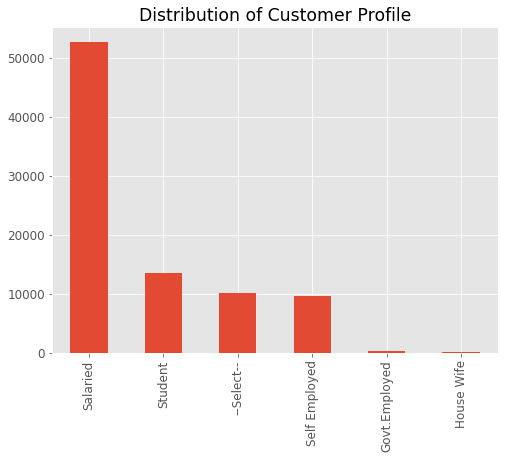

In [167]:
data['Customer_Profile'].value_counts().plot(kind='bar',title='Distribution of Customer Profile');

Majority of customers are salaried. But these customer profiles won't help us much in our analysis.

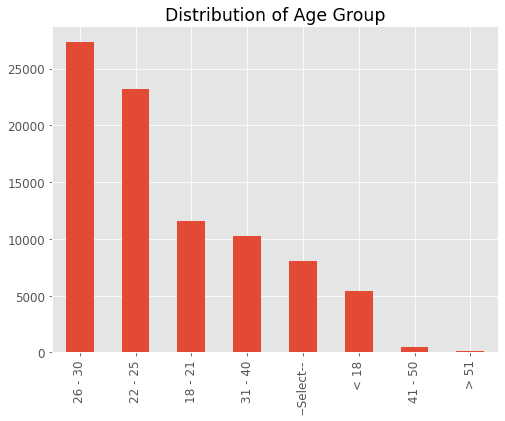

In [168]:
data['Age_Group'].value_counts().plot(kind='bar',title='Distribution of Age Group');

18-40 is the majority age of the Customers on call. Distribution of age might not be relevant for our study.

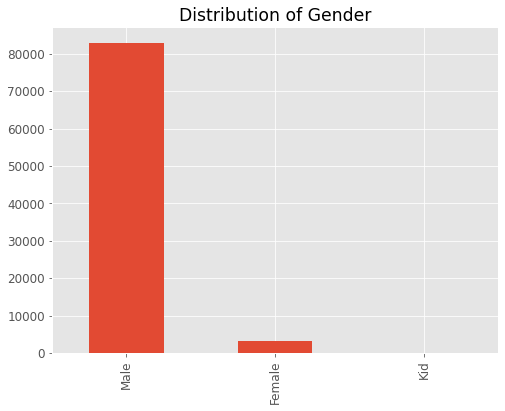

In [169]:
data['Gender'].value_counts().plot(kind='bar',title='Distribution of Gender');

Majority are male, therefore this feature is also irrelevant.

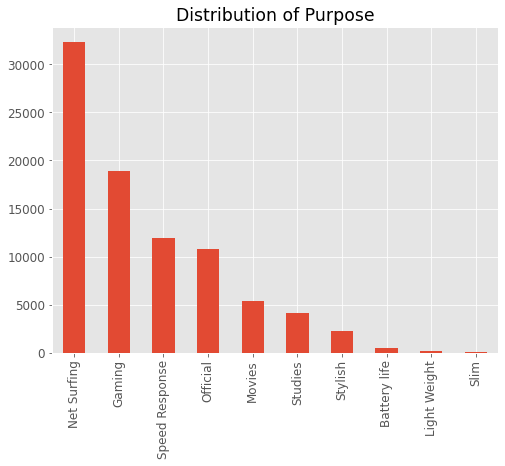

In [170]:
data['Purpose'].value_counts().plot(kind='bar',title='Distribution of Purpose');

In [287]:
purpose = round(data["Purpose"].value_counts() / len(data["Purpose"]) * 100,2)
print(purpose)
labels = list(purpose.index)
values = purpose.values.tolist()
colors = ['#FAAC58','#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#088A85', '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']
product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))

layout = go.Layout(title='Distribution of Purpose')
fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)

Net Surfing       37.40
Gaming            21.83
Speed Response    13.77
Official          12.49
Movies             6.26
Studies            4.79
Stylish            2.56
Battery life       0.58
Light Weight       0.22
Slim               0.11
Name: Purpose, dtype: float64


Distribution of purpose doesn't provide much value to our analysis if we are reducing the number of calls. 

In [171]:
p_product = round(data["Product_Type"].value_counts() / len(data["Product_Type"]) * 100,2)
print(p_product)
labels = list(p_product.index)
values = p_product.values.tolist()
colors = ['#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']
product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))

layout = go.Layout(title='Distribution of Product Types')
fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)

Notebook                    76.46
Mobile Phone                 9.34
Tablet                       7.07
Accessaries                  2.89
Desktop                      2.18
AIO                          1.45
Software And Peripherals     0.61
Name: Product_Type, dtype: float64


Majority of the calls are regarding Notebooks.

In [282]:
#unique comments in our dataset.
data['Comments'].nunique()

41943

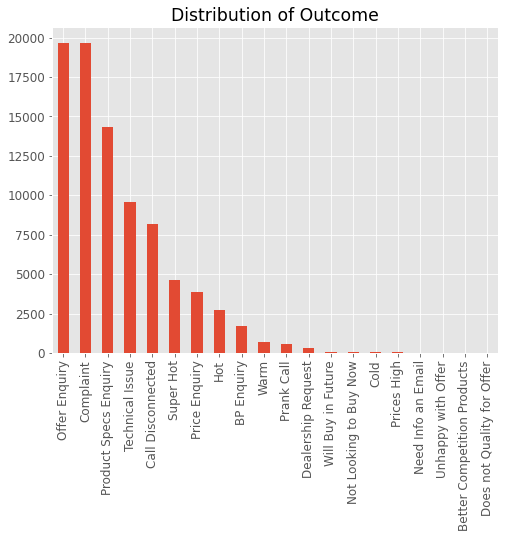

In [173]:
data['Outcome'].value_counts().plot(kind='bar',title='Distribution of Outcome');

This feature is important, also we can club the values with less than 1000 count to a new value 'Other'. We'll see that later.

So the dataset contains 86,410 rows and 9 columns. But we only need information such as Product_type, Comments, and Outcome. Therefore, I'm making a datset with these 4 columns only.

In [283]:
df = data[['Product_Type','Comments','Outcome']].copy()

I am only considering those Outcomes that have at least 1000 comments and products that have more than 1500 calls. I am doing this to make sure that I have a sufficient number of comments for each outcome. Here, we will use lambda functions with filter() to filter our dataset.

In [284]:
df=df.groupby('Outcome').filter(lambda x:len(x)>1000).reset_index(drop=True)
print('Number of different outcomes=>',len(df['Outcome'].unique()))
df=df.groupby('Product_Type').filter(lambda x:len(x)>1500).reset_index(drop=True)
print('Number of different products=>',len(df['Product_Type'].unique()))

Number of different outcomes=> 9
Number of different products=> 5


In [285]:
outco = round(df["Outcome"].value_counts() / len(df["Outcome"]) * 100,2)
print(outco)
labels = list(outco.index)
values = outco.values.tolist()
colors = ['#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']
product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))

layout = go.Layout(title='Distribution of Outcomes')
fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)

Offer Enquiry            23.66
Complaint                23.61
Product Specs Enquiry    16.90
Technical Issue          11.28
Call Disconnected         9.76
Super Hot                 5.10
Price Enquiry             4.55
Hot                       3.09
BP Enquiry                2.06
Name: Outcome, dtype: float64


That’s it! We are finished with the basic data-preprocessing part. Let’s move to the next section – cleaning text data.

## Cleaning Text Data in Python

Generally, text data contains a lot of noise either in the form of symbols or in the form of punctuations and stopwords. Therefore, it becomes necessary to clean the text, not just for making it more understandable but also for getting better insights.

For our dataset, the Comments column contains comments of call by our customer center , which are longer in length, and our complete analysis will be based on this data. Therefore, it becomes necessary to clean this thoroughly. The best way of determining data cleaning steps is by taking a look at some Comments from the dataset:

In [293]:
for index,text in enumerate(df['Comments'][380:390]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 Do Gear Offer Enquiry
Review 2:
 Enquired about the Z500 with the mtm number 59-380463
Review 3:
 Informed customer to send the documents once again for the 'Do Gear' offer registration
Review 4:
 DO Gear Offer Enquiry
Review 5:
 Enquiry for A390 & A800
Review 6:
 Voucher ID not received yet. Call back immediately.
Review 7:
 Customeer enquired about specifications of A60+. Provided info.
Review 8:
 Customer enquired about redeeming E-voucher. Provided info.
Review 9:
 Enquired about thedostore.com
Review 10:
 Customer enquired about G580 MTM 59-351467 assisted with the same


Here, you can see that we have some contractions like “haven't”, numbers like “59-380463” and punctuations like “,”, “!” and “.” present in the comments. We’ll handle these by performing the below operations:

- Expand contractions
- Lowercase the reviews
- Remove digits
- Remove punctuations

So, let’s start by expanding contractions.

### Expand Contractions
Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis of the reviews.

Here, I have created a dictionary of common English contractions that I will use for mapping the contractions to their expanded forms:

In [251]:
# Dictionary of English Contractions
contractions_dict = {"aren't": "are not","&": "and",
                     "can't": "cannot",
                     "couldn't": "could not",
                     "didn't": "did not","doesn't": "does not",
                     "don't": "do not", "dept": "department",
                     "num": "number", "enq":"enquire","abt":"about",
                     "hasn't": "has not","haven't": "have not"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the Comments
df['Comments']=df['Comments'].apply(lambda x:expand_contractions(str(x)))

Now that we have expanded the contractions, it’s time to lowercase the words.


### Lowercase the Comments

In NLP, models treat words like Enquire and enquire differently, even if they are the same. Therefore, to overcome this problem, we lowercase the words. Here, I am using the lower() function available in Python for converting text to lowercase:

In [252]:
df['cleaned']=df['Comments'].apply(lambda x: x.lower())

### Remove digits
Next, we need to remove numbers from the comments. I am doing this because digits do not give much importance to the main words. To do this, I am using regular expressions with lambda functions.

In [253]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\d*','', x))

### Remove Punctuations
Punctuations are the marks in English like commas, hyphens, full stops, etc. These are important for English grammar but not for text analysis. Therefore, they need to be removed:

In [254]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))


Here, string.punctuations function contains all the punctuations and we use regular expressions to search them in the text and remove them. Finally, we still have some extra spaces present in the data. Let’s remove them:

In [255]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [256]:
for index,text in enumerate(df['cleaned'][65:70]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 assisted with offer details
Review 2:
 call drop
Review 3:
 assisted with offer details
Review 4:
 customer enquireuireuired about technical number
Review 5:
 drop call


## Preparing Text Data for Exploratory Data Analysis (EDA)

In this section, we’ll do the following things:

- Stopwords Removal
- Lemmatization
- Create Document Term Matrix

Stopwords are the most common words of a language like ‘I’, ‘this’, ‘is’, ‘in’ which do not add much value to the meaning of a document. These values are removed to decrease the dataset size and increase focus on meaningful words.

Lemmatization is a systematic process of reducing a token to its lemma. It uses vocabulary, word structure, part of speech tags, and grammar relations to convert a word to its base form.

In [257]:
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


We have removed stopwords and lemmatized our comments successfully. Let’s group them according to the Outcome.

In [211]:
df_grouped=df[['Outcome','lemmatized']].groupby(by='Outcome').agg(lambda x:' '.join(x))
df_grouped.head()

lemmatized
Outcome                                                             
BP Enquiry         customer enquireuire smartphone aa aiai get kn...
Call Disconnected  drop drop assist info customer disconnect disc...
Complaint          customer recive evoucherticket idsok customer ...
Hot                customer want purchase line th oct customer wa...
Offer Enquiry      customer call know sheild warrenty assist acco...

In [258]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
#'customer' is in every comment so we can drop it as it doesn't bring any value to our analysis
df_dtm.drop('customer',axis=1,inplace=True) 
df_dtm.head(3)

aa  aabout  aaccordingly  aacordingly  aadvise  aai  \
Outcome                                                                  
BP Enquiry          1       0             0            0        0    0   
Call Disconnected   1       0             0            0        0    0   
Complaint           0       0             0            1        0    0   

                   aaiste  aaj  aakash  aalready  ...  zu  zupcome  zvc  zvw  \
Outcome                                           ...                          
BP Enquiry              0    0       0         0  ...   0        0    0    0   
Call Disconnected       0    0       1         0  ...   0        0    0    0   
Complaint               1    1       0         0  ...   0        0    1    1   

                   zwithin  zxi  zyq  zzq  zzr  zzz  
Outcome                                              
BP Enquiry               0    0    0    0    0    0  
Call Disconnected        0    0    0    0    0    0  
Complaint                0    1    2    1    1    1  

[3 rows x 9077 columns]

Finally, we have completed all the procedures required before starting our analysis, and we have our dataset present in the exact format needed for the exploration stage.

## Exploratory Data Analysis

Now let's look at the common words present in the comments for each outcome. For this, I will use the document term matrix created earlier with word clouds for plotting these words. Word clouds are the visual representations of the frequency of different words present in a document. It gives importance to the more frequent words which are bigger in size compared to other less frequent words.

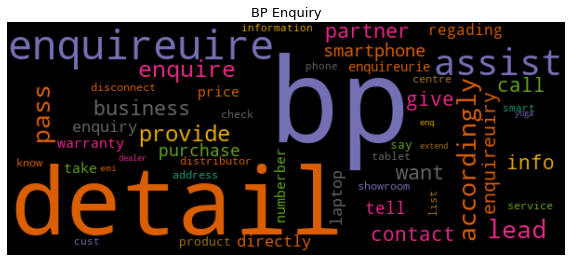

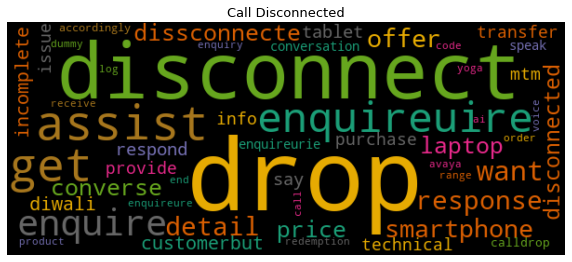

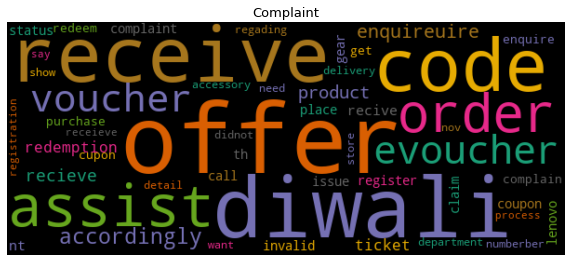

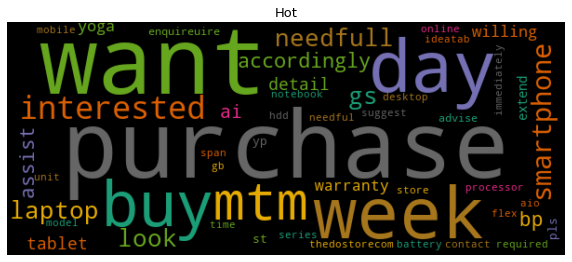

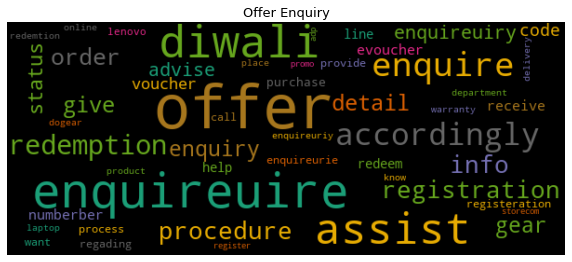

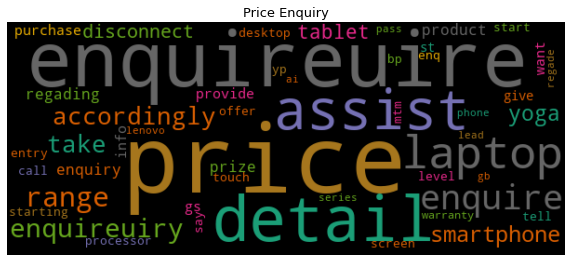

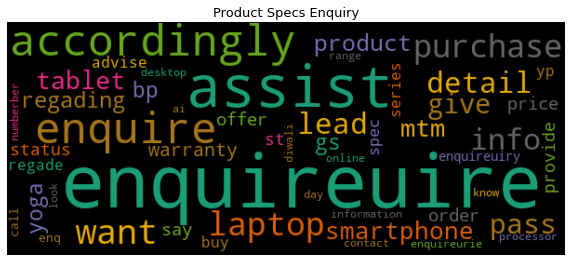

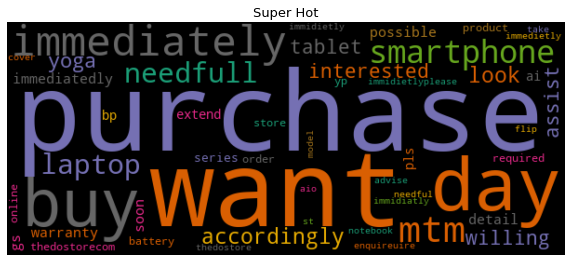

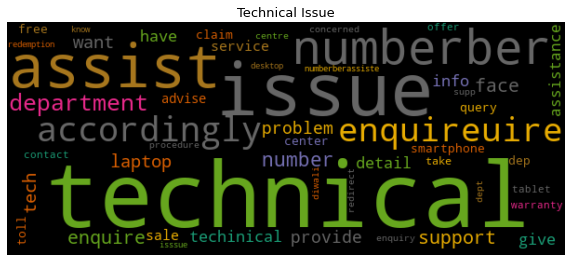

In [260]:
def generate_wordcloud(data,title):
    wc = WordCloud(width=600, height=250, max_words=50,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
    
df_dtm=df_dtm.transpose()
# Plotting word cloud for each product
for index,outcome in enumerate(df_dtm.columns):
    generate_wordcloud(df_dtm[outcome].sort_values(ascending=False),outcome)

Above are the most common words in comments for different outcomes. Let's check these outcomes grouped with products for better understanding.

In [261]:
df['Product_Outcome'] = df['Product_Type'] + '-' + df['Outcome']
df.head(3)

Product_Type                                           Comments  \
0       Tablet                                         Call drop.   
1     Notebook                                          Call drop   
2     Notebook  While assisting with the info, Customer discon...   

             Outcome                                            cleaned  \
0  Call Disconnected                                          call drop   
1  Call Disconnected                                          call drop   
2  Call Disconnected  while assisting with the info customer disconn...   

                        lemmatized             Product_Outcome  
0                             drop    Tablet-Call Disconnected  
1                             drop  Notebook-Call Disconnected  
2  assist info customer disconnect  Notebook-Call Disconnected

In [262]:
df_grouped2=df[['Product_Outcome','lemmatized']].groupby(by='Product_Outcome').agg(lambda x:' '.join(x))
df_grouped2.head(3)

lemmatized
Product_Outcome                                                                 
Accessaries-BP Enquiry         assist bp detail bp enquireuireuiry customer e...
Accessaries-Call Disconnected  customer enquireuireuire ram assisting get dis...
Accessaries-Complaint          customer recive ordered product customer recei...

In [263]:
data=cv.fit_transform(df_grouped2['lemmatized'])
df_dtm2 = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm2.index=df_grouped2.index
df_dtm2.drop('customer',axis=1,inplace=True) #dropping customers-doesn't bring any value
df_dtm2.head(3)
df_dtm2 = df_dtm2.transpose()  # for wordcloud

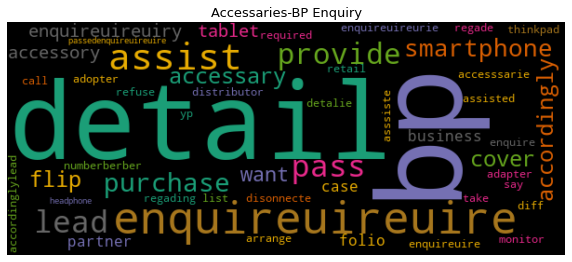

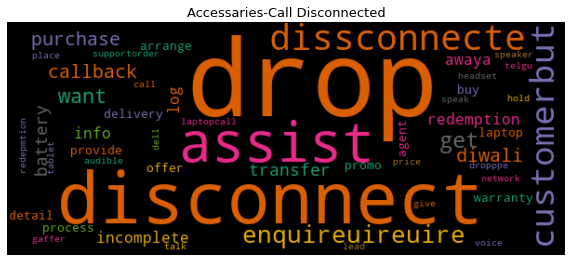

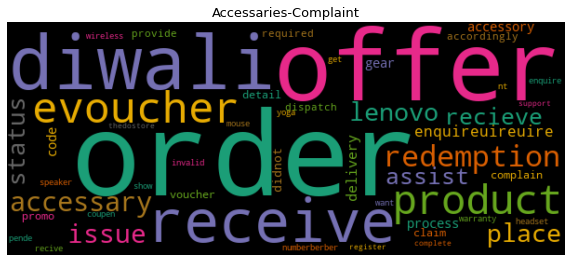

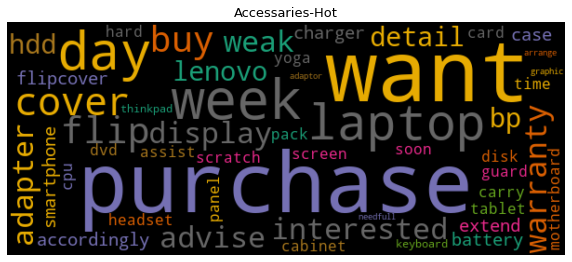

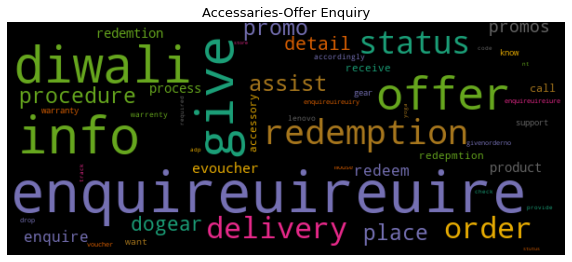

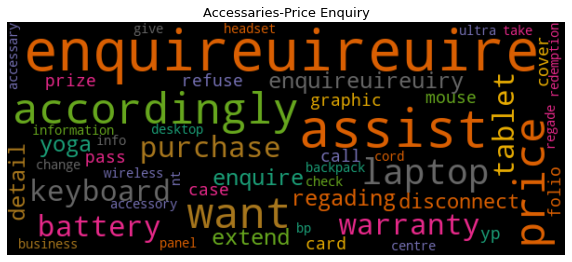

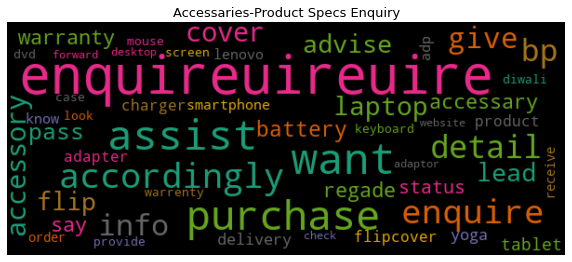

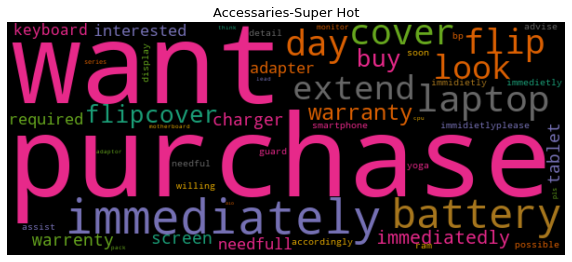

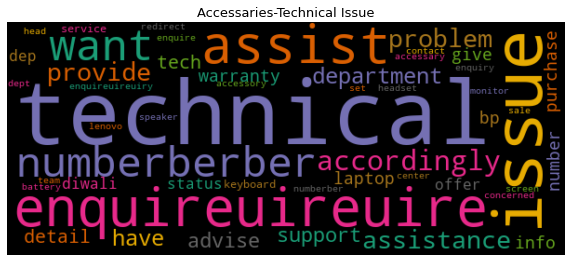

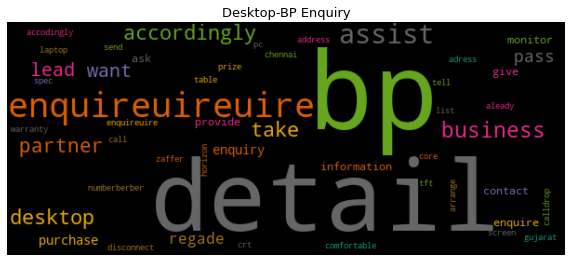

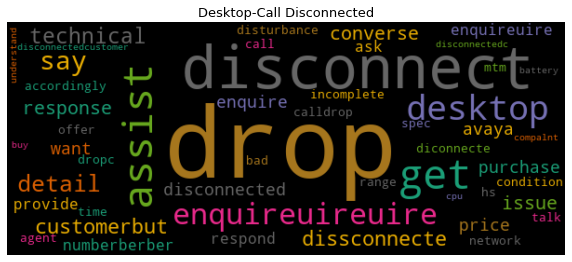

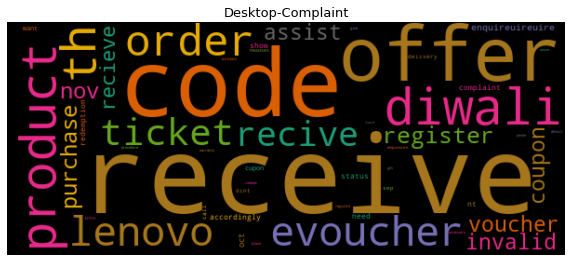

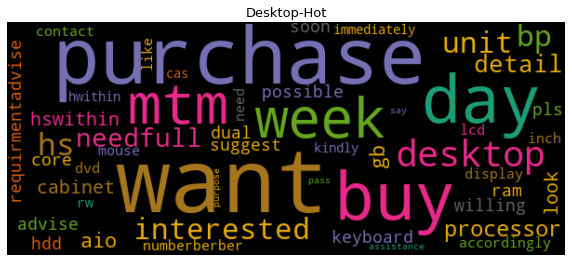

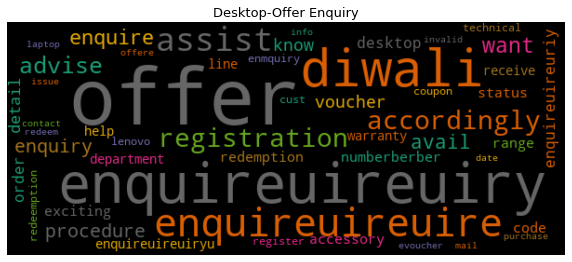

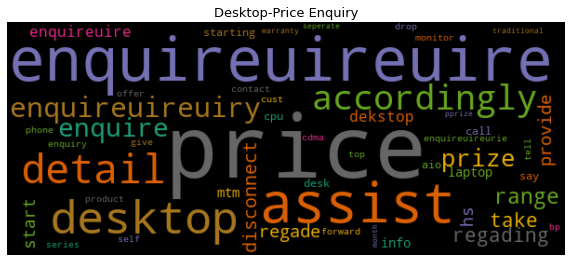

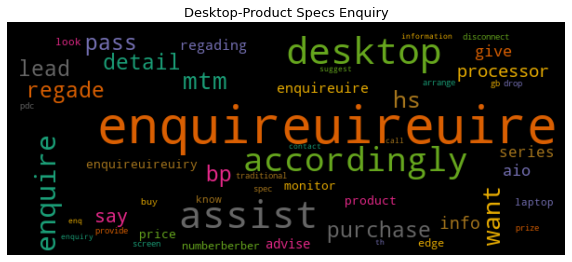

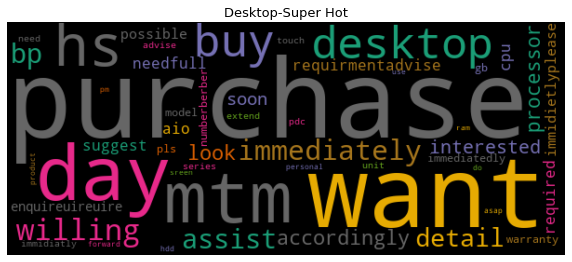

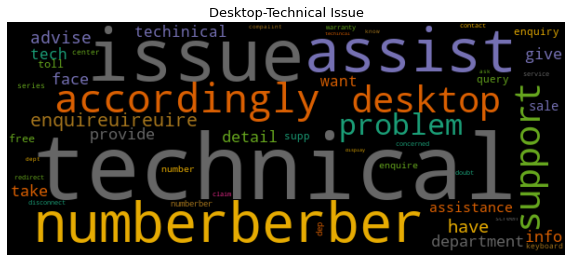

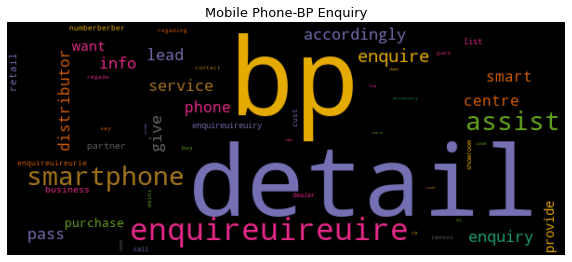

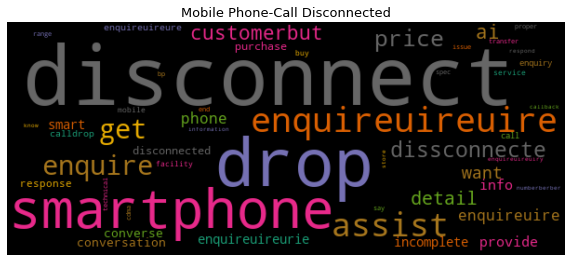

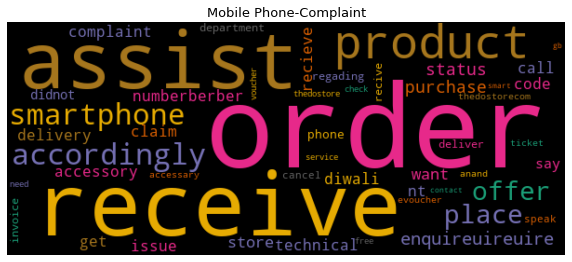

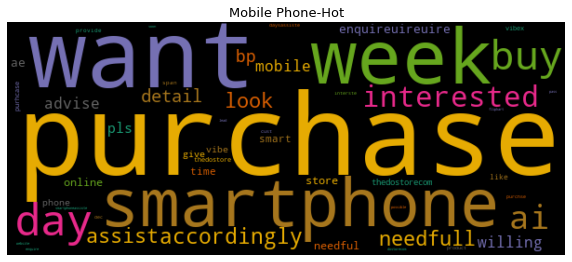

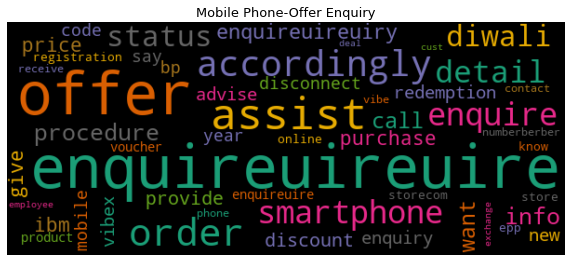

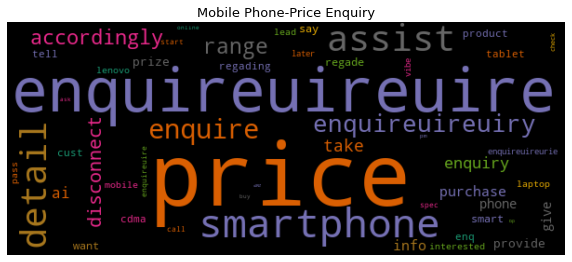

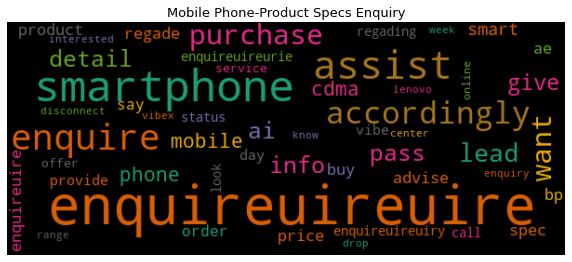

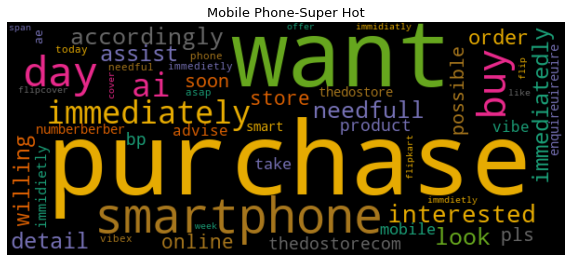

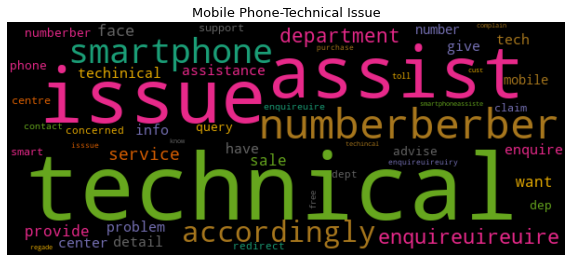

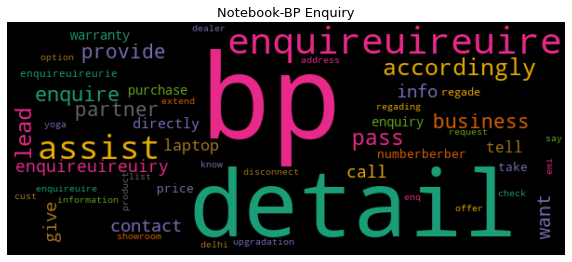

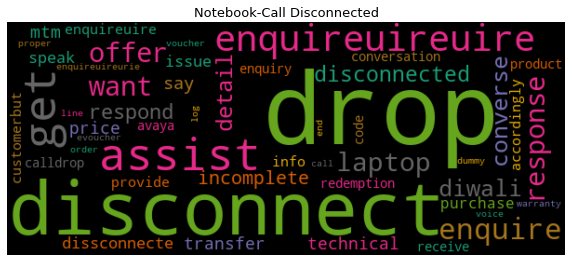

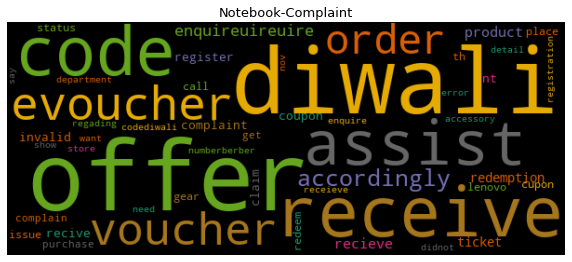

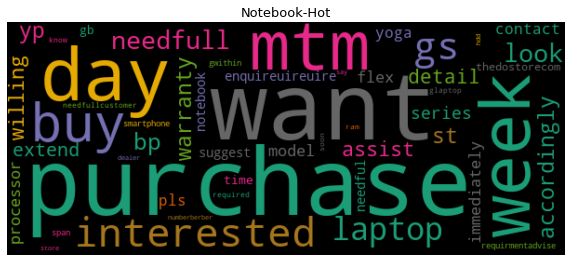

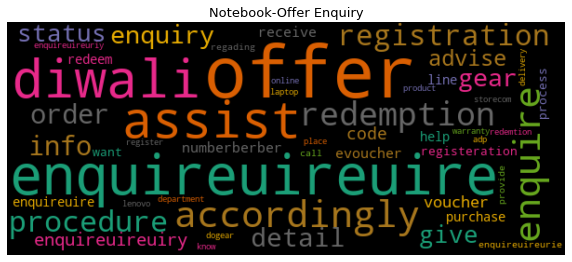

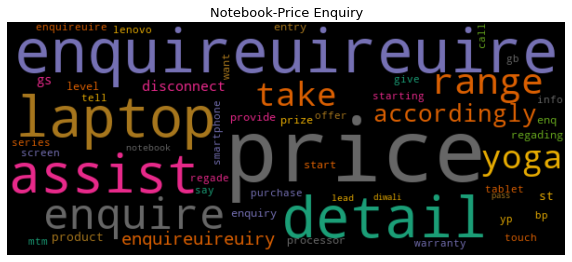

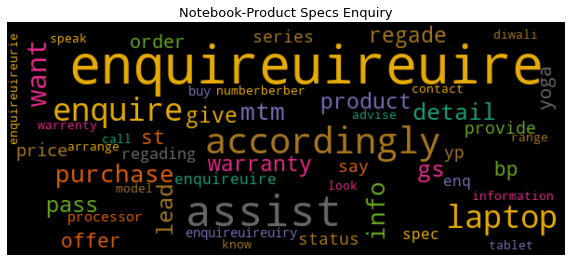

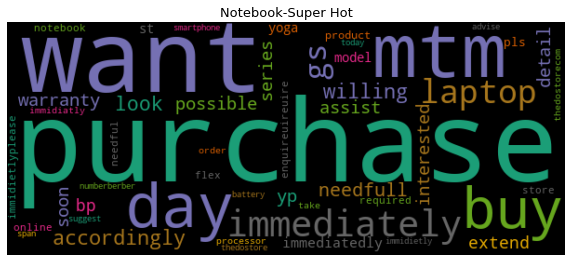

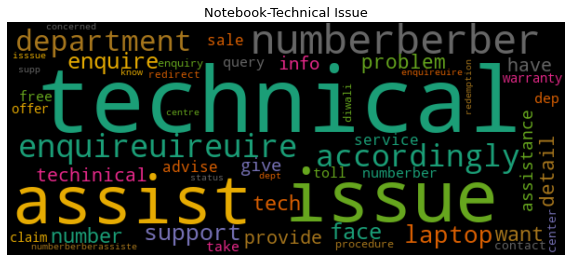

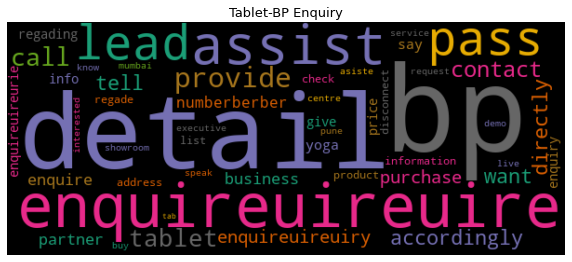

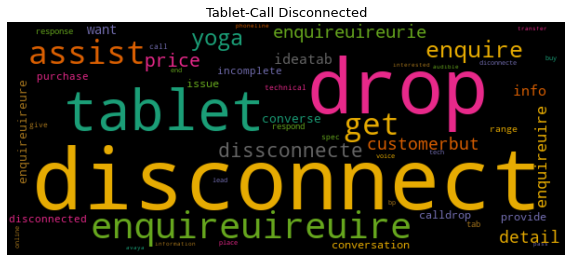

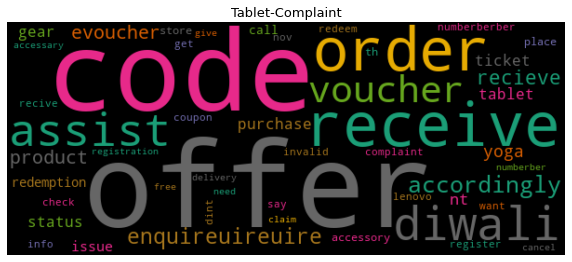

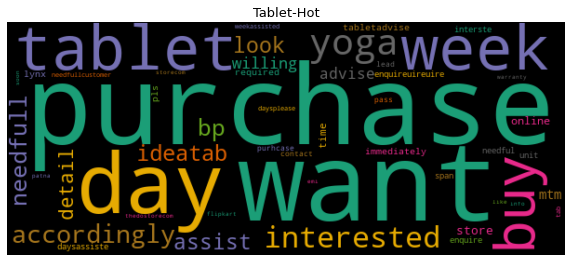

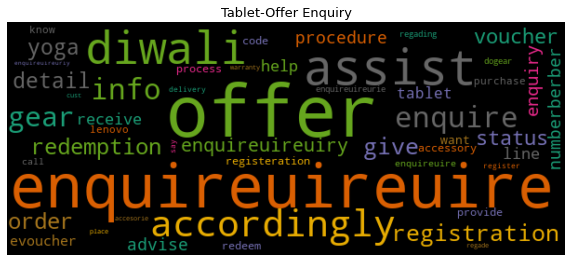

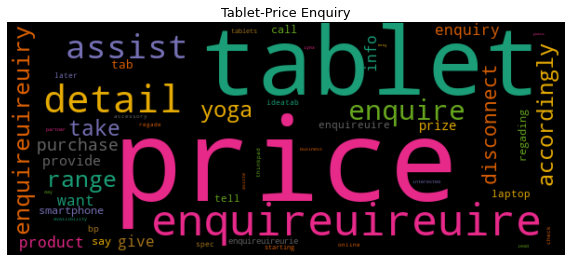

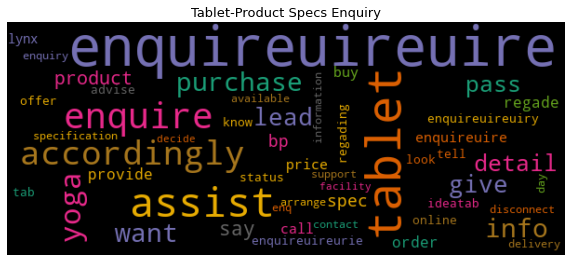

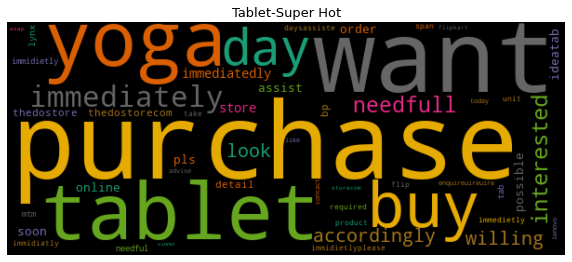

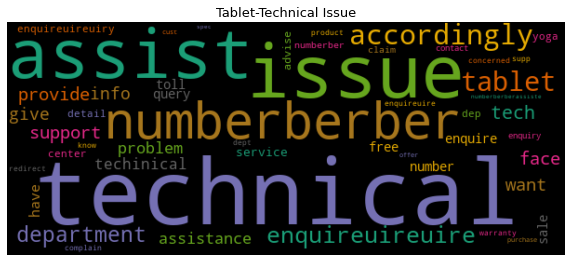

In [274]:
def generate_wordcloud2(data,title):
    wc = WordCloud(width=600, height=250, max_words=50,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

for index,outcome in enumerate(df_dtm2.columns):
    generate_wordcloud2(df_dtm2[outcome].sort_values(ascending=False),outcome)

We have the above keywords for different products and outcomes. Let's check which combination of products and outcomes get's the most number of calls and then we can make recommendations based on the above wordclouds.

In [265]:
df_grouped3=df[['Product_Type','Outcome']].groupby(['Product_Type','Outcome']).size()
df_grouped3.head(44)

Product_Type  Outcome              
Accessaries   BP Enquiry                  46
              Call Disconnected          127
              Complaint                 1070
              Hot                         69
              Offer Enquiry              441
              Price Enquiry               33
              Product Specs Enquiry      244
              Super Hot                  352
              Technical Issue             83
Desktop       BP Enquiry                  49
              Call Disconnected          410
              Complaint                  105
              Hot                         80
              Offer Enquiry              223
              Price Enquiry              121
              Product Specs Enquiry      377
              Super Hot                  109
              Technical Issue            347
Mobile Phone  BP Enquiry                 245
              Call Disconnected          654
              Complaint                  266
              Hot  

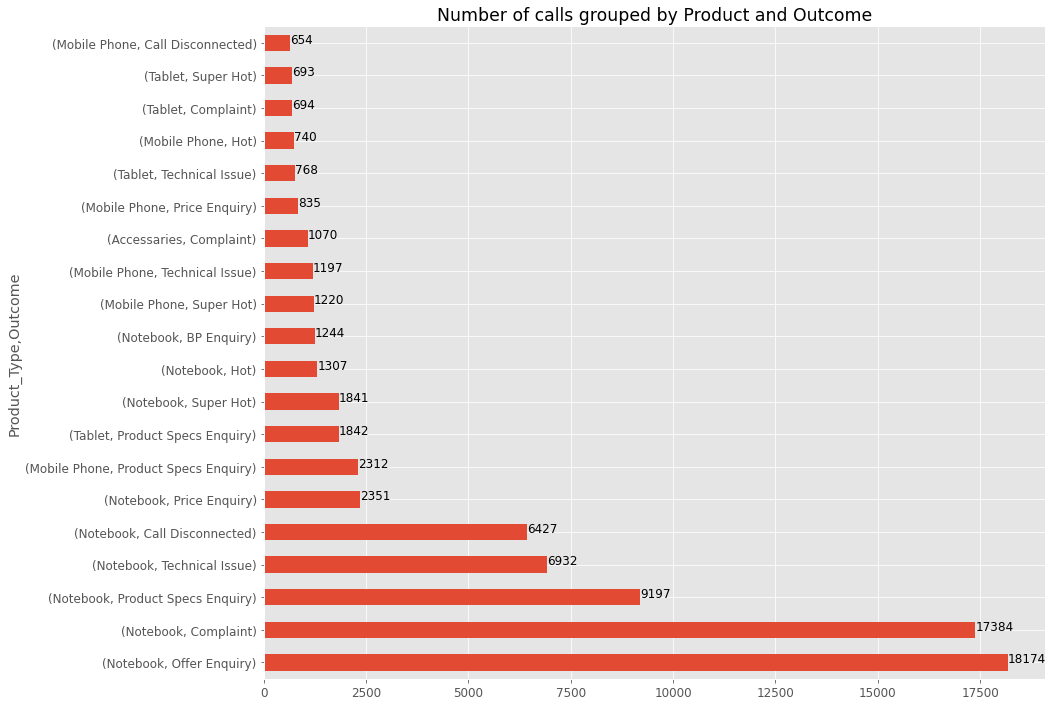

In [273]:
plt.figure(figsize=(14,12))
df_grouped3.sort_values(ascending=False)[:20].plot(kind='barh',
                                                   title='Number of calls grouped by Product and Outcome')
for index, value in enumerate(df_grouped3.sort_values(ascending=False)[:20]):
    plt.text(value, index,str(value))
plt.show()


As we can see, the majority of the calls are for Notebook offers, complaints, specs enquiry.
Product Specs Enquiry calls are also common for Mobile Phones and Tablets.

Now let's look at the wordclouds for the most calls Product+Outcome and make recommendations whereever possible on reducing call volumes and handling calls better to increase customer sales.

## Recommendations

#### High Priority Recommendations

- **Notebook-Offer Enquiry:** We should make this process more understandable, transparent and easily interpretable for the customers as a huge chunk of calls are for offer enquires of Notebook. We can add dedicated blogs or videos to explain the process and discounts with examples. Increasing the transparency during Diwali offers can lead to significant call drops as a lot of customers enquire about Diwali offers.

- **Notebook-Complaint:** Again a huge number of calls regarding complaints on Diwali offers, coupons, evouchers and code. Making the offer process more transparent during Diwali and attaching files/videos for better explanation and redemption of these offers can significantly reduce the call volumes.


- **Notebook-Technical Issues:** We can add an additional Technical Issues FAQ just like the FAQ page under the Customer Support where we can write the general technical issues and ways to resolve them. We can also add the email id's of the different Technical departments, so that users can reach out to them directly. These steps should reduce the calls regarding technical issues.

These 3 Outcomes namely "Offer Enquiry, Complaint and Technical Issues" together got 58.6% of the calls, and if we apply the above recommendations, the number of calls can reduce drastically. Even if we apply the recommendations on Notebook itself, the calls should drastically reduce as majority of the calls are regarding Notebooks.

#### Low Priority Recommendations

- **Notebook-Product Specs Enquiry:** As we have already added all the features and technical details on our portal, we can't do much here except adding the details on how to avail warrenty and conditions for the same, by adding the 'Search by Serial Number' section directly at the bottom of the product page on our website. We can also add a product comparision option on the same page as it maybe me possible, that the customers find it difficult to decide which specs are better and how it effects the pricing. However, this is a less priority recommendation.


### To increase customer sales

- Our customer center callers should have pdfs or booklets of different devices with them at all times. The pdfs can be categorized by the purpose of the product and their prices. Example a pdf of Notebooks can list different laptops for gaming, general all rounders, speed performance, battery life and others. As a result, when we have super hot and hot leads, we can ask them their purpose and budget, and we can quickly recommend them the perfect device clubbed with the offers on our website. This approach might lead to higher sales by our in house team.